## Business Understanding



The average sales price of new homes sold in the U.S. is US$388,000. The house price mainly dependent on Location, size and condition ... these factors influence a home’s value. 

The goal of this notebook is to predict house prices using one basic machine Linear Regression,
and Random Forest , in this mainly we will look at data exploration and data cleaning.We use The Kaggle House Prices datasets. 

We are interested to answer the following two questions:

 Q1: Get an overview of the our traget variable and find out what distribution its follow ? 
 
 Q2 : What are the most important  variables to our traget ?
  
 Q3: What is the best model that give us the best result ?
 
 Q4: Can you improve the accuracy of a model ?


In [1]:
# import important libraries
import numpy as np
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)

## Load data

In [2]:
df = pd.read_csv('House_data.csv') 

In [3]:
df.shape

(2919, 81)

## Explore and clean data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

#### checking for missing values missing value

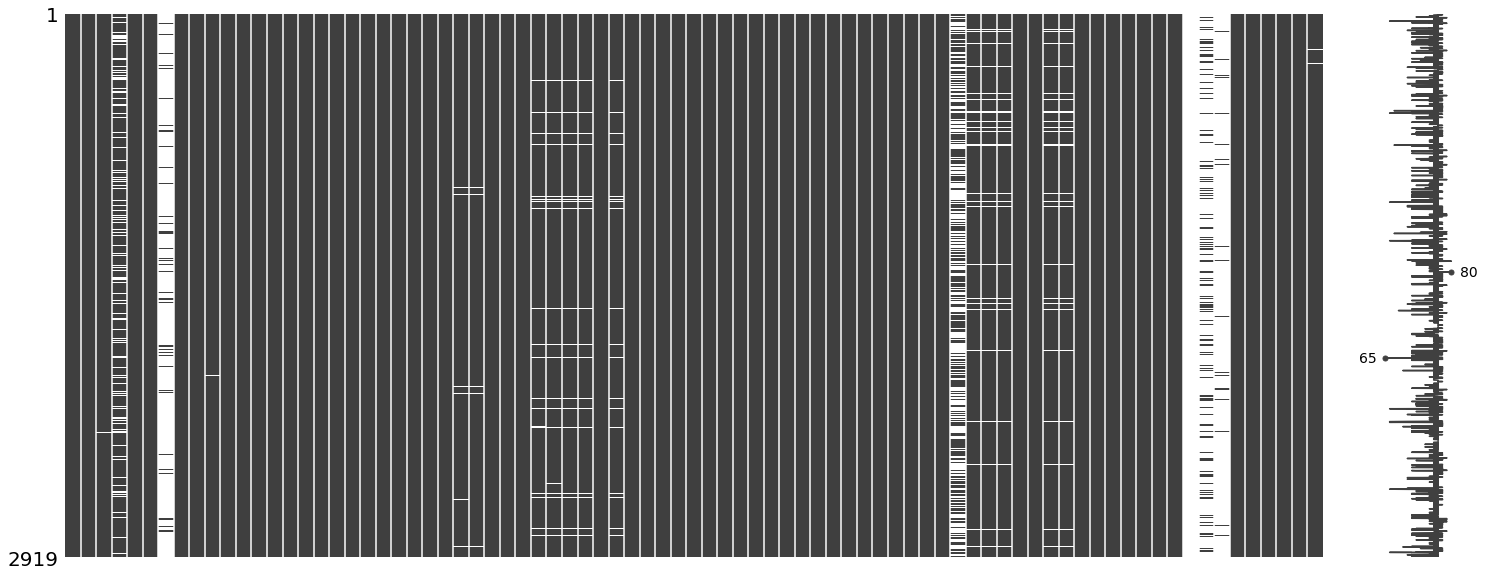

In [5]:
msno.matrix(df);

From above we can tell they are misssing values in our data 

In [6]:
np.sum(np.sum(df.isnull()) != 0)  # there are 35 columns in our data have missing value

35

In [7]:
nan = [(c,df[c].isna().mean()*100) for c in df]
nan = pd.DataFrame(nan, columns=["column", "%"])
pd.set_option('display.max_row', 500)
nan=nan[nan['%'] !=0.00000].sort_values("%", ascending=False)
nan

,column,%
72,PoolQC,99.657417
74,MiscFeature,96.402878
6,Alley,93.216855
73,Fence,80.438506
57,FireplaceQu,48.646797
3,LotFrontage,16.649538
64,GarageCond,5.447071
59,GarageYrBlt,5.447071
60,GarageFinish,5.447071
63,GarageQual,5.447071


From above we can safely drop first 5 columns since they have more than 50% missing value 

In [8]:
df = df.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],axis=1)

In [9]:
df  = df.dropna(subset=['SalePrice'], axis=0) # we will drop the missing value in our response since it is only 1 %

since we dont know much about our data we can replace the the missing value in our categorical variables with mode

In [63]:
df_object = df.select_dtypes(include=['object'])
for column in df_object.columns:
    df_object[column].fillna(df_object[column].mode()[0], inplace=True);

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


We will do the same for continuous variables. we will replace nan with the mean 

In [15]:
df_number = df.select_dtypes(include=['int64','float64'])
df_number = df_number.fillna(df_number.mean())

In [16]:
df_final = pd.concat([df_number,df_object], axis=1) # combining the two data

In [17]:
np.sum(np.sum(df_final.isnull()) != 0)  # we just wnana make sure there is no missing value in our data 

0

In [18]:
df_final.shape

(2914, 76)

In [19]:
df= df_final # renaming our data to df 

### dummy variable all categorical variables

In [20]:

#Pull a list of the column names of the categorical variables
cat_cols_lst = df.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [21]:


#Pull a list of the column names of the categorical variables
cat_df = df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(df, cat_cols_lst, dummy_na=False) #Use your newly created function

# Show a header of df_new to check
print(df_new.shape)

(2914, 234)


## Explore data

We want get an overview of the our traget variable and find out what distribution its follow

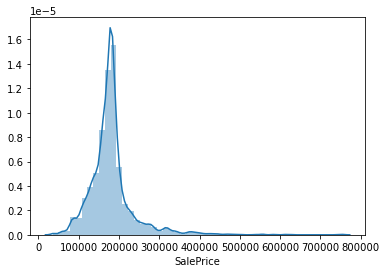

In [23]:
sns.distplot(df_new['SalePrice']);

As we see, the target variable SalePrice is not normally distributed.
This can reduce the performance of the ML regression models because some assume normal distribution,

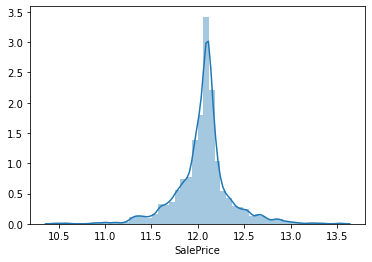

In [24]:
df_new['SalePrice'] = np.log(df_new['SalePrice'])

sns.distplot(df_new['SalePrice']);
#  we will make a log transformation, the resulting distribution looks much better.

### Q2 : What are the most important  variables to our traget ?
to anser this question we need to see  the correlation between the variables

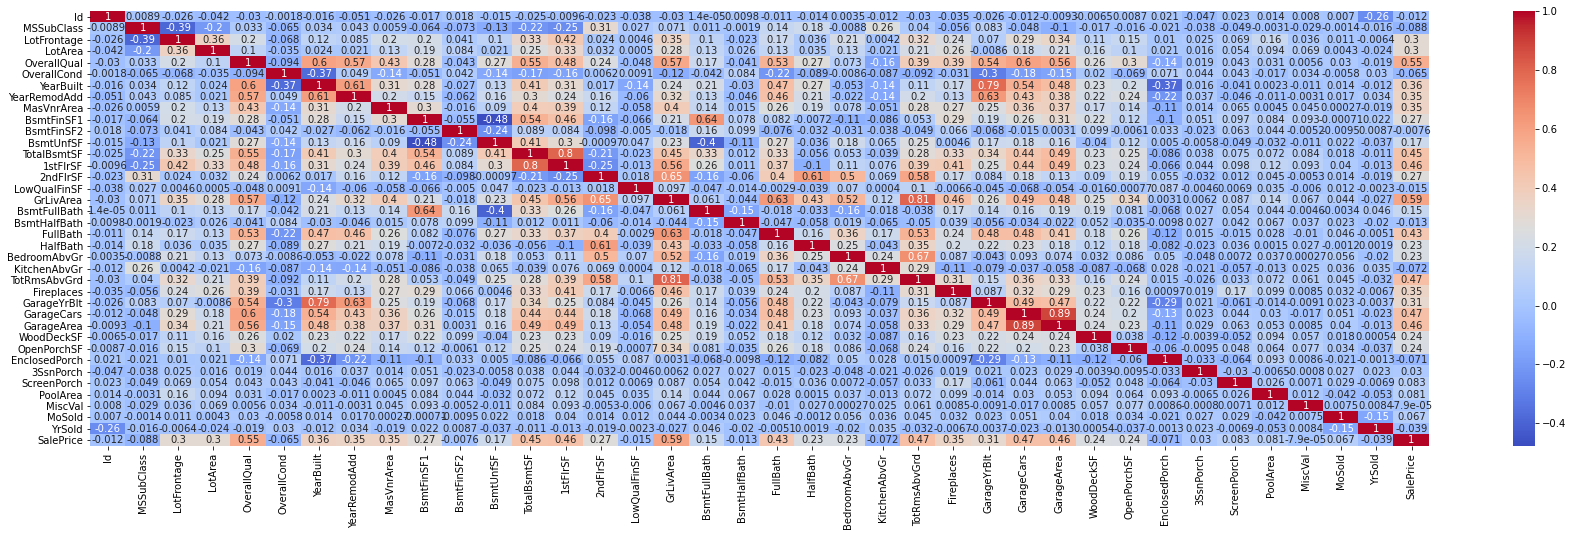

In [25]:
plt.figure(figsize=(30,8))
sns.heatmap(df.corr(),cmap='coolwarm',annot = True)
plt.show()

In [26]:
corr =df_new.corr()
corr=corr[['SalePrice']].sort_values('SalePrice', ascending=False)
corr.head(20)

,SalePrice
SalePrice,1.000000
GrLivArea,0.578034
OverallQual,0.562809
GarageCars,0.493404
GarageArea,0.480454
TotRmsAbvGrd,0.467538
FullBath,0.456609
1stFlrSF,0.453925
TotalBsmtSF,0.448546
YearBuilt,0.402549


From above we can see the the most important variables to Sale Price, we will consider any variables have more than 4 % corr have good relationship:

 1-GrLivArea 2-OverallQual 3-GarageCars 4-GarageArea 5-TotRmsAbvGrd 6-FullBath 7-1stFlrSF 
8-TotalBsmtSF 9-YearBuilt 

## Modeling

We will build tow models and evaluate their performances with R-squared metric. Additionally, we will gain insights on the features that are strong predictors of house prices.

### Linear Regression

In [71]:
X= df_new.drop(['SalePrice','Id'], axis=1)
y=df_new['SalePrice']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression() 

lm_model.fit(X_train, y_train) 

LinearRegression()

In [73]:
y_test_preds = lm_model.predict(X_test)# Predictions here
r2_test = r2_score(y_test, y_test_preds) # Rsquared here

# Print r2 to see result
r2_test

0.34784422059260156

It looks like our test score is 4 % which is very low . we will try to amprove this later !

### Random Forest 

In [74]:
 
Rf = RandomForestRegressor(n_estimators = 20,
                              criterion = 'mse',
                              random_state = 20,
                              n_jobs = -1)
Rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=20)

In [75]:
y_test_preds_RF = Rf.predict(X_test)# Predictions here
r2_test_RF = r2_score(y_test, y_test_preds_RF) # Rsquared here

# Print r2 to see result
r2_test_RF

0.40435075494866224

it looks like we improve performance for our model by 7%

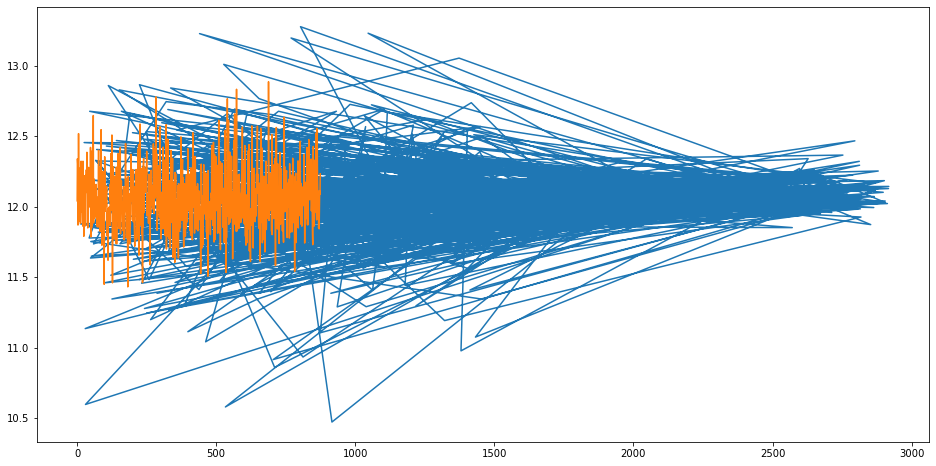

In [76]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(y_test_preds_RF, label = 'predict')
plt.show()

In [ ]:
result = pd.DataFrame({"Actual":y_test,"predictor":y_test_preds})
result.to_excel('result.xlsx') 

## Q4: Can you improve the accuracy of a model ?

we are get low accuracy in our model before that might be because we include categorical variables.
We will try to fit out model again with the numeric data only 

In [57]:
# set the target and predictors
y=df_new['SalePrice']  # target

# use only those input features with numeric data type 
df_temp = df_new.select_dtypes(include=["int64","float64"]) 
X = df_temp.drop(["SalePrice"],axis=1)  # predictors

In [58]:
 
Rf = RandomForestRegressor(n_estimators = 20,
                              criterion = 'mse',
                              random_state = 20,
                              n_jobs = -1)
Rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=20)

In [65]:
y_test_preds_RF = Rf.predict(X_test)# Predictions here
r2_test_RF = r2_score(y_test, y_test_preds_RF) # Rsquared here

# Print r2 to see result
r2_test_RF

0.8109156236354934

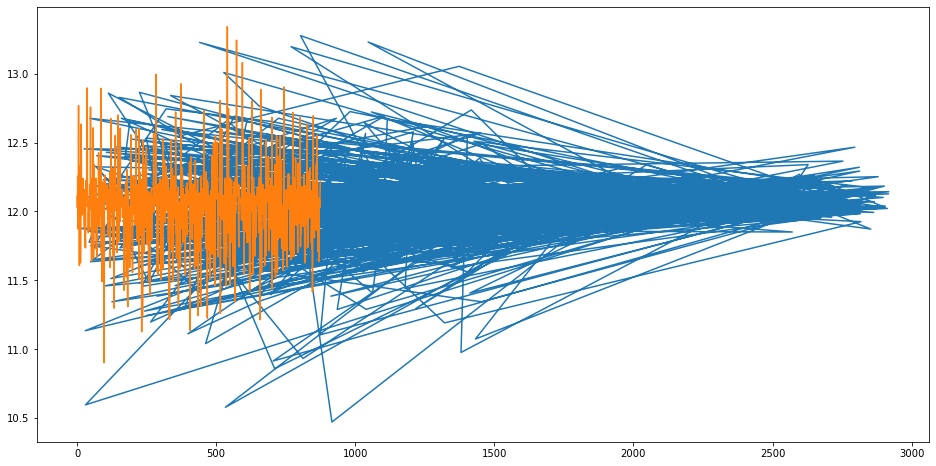

In [68]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(y_test_preds_RF, label = 'predict')
plt.show()

## Conclusion

We conclude that GrLivArea, OverallQual, GarageCars  and GarageArea have big influence a home’s value.
Random Forest is the most accurate model for predicting the house price. It scored an estimated accuracy of 81%,
We notice that our model did not performance good with including the categorical variables. this is might happened becasuse there is no relationship between SalePrice and these variables.